In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from sklearn import preprocessing
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
import time
import nltk
import warnings
warnings.filterwarnings("ignore")


In [142]:
df = pd.read_excel("C:/Users/jllce/Downloads/classificacao_assuntos.xlsx")

In [143]:
df.isnull().sum()

tweets    0
label     0
dtype: int64

In [144]:
# Se tiver valores nulos, usar o código abaixo

# df = df[~df['label'].isnull()]
# df

In [145]:
df1 = df["tweets"]
df2 = df["label"]

In [146]:
def cleanTxt(text):
  import re
  text = text.lower()
  text = re.sub(r"@([a-zA-Z0-9_]{1,50})",'',str(text)) 
  text = re.sub(r'(?:\@|https?\://)\S+','',text)
  text = re.sub(r'\d+','', text)
  text = re.sub(r"[-()\"#/;:<>{}-~=|.?,]","",text)
  return text

def removeEmojis(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  return text

def removeStopWords(text):
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [stemmer.stem(i) for i in text.split() if not i in stopwords]
    return (" ".join(words))


tweets_tratados = df1.apply(cleanTxt)
tweets_tratados = tweets_tratados.apply(removeEmojis)
tweets_tratados = tweets_tratados.apply(removeStopWords)
tweets = list(tweets_tratados)

In [147]:
label_encoder = preprocessing.LabelEncoder()
labels = pd.DataFrame(label_encoder.fit_transform(df2), columns=["Label"], index = df.index)
labels

,Label
0,2
1,1
2,1
3,1
4,0
...,...
11045,2
11046,1
11047,1
11048,1


In [148]:
labels.value_counts()

Label
2        4095
1        3973
3        1803
0        1179
dtype: int64

In [149]:
from keras.utils.np_utils import to_categorical
y = to_categorical(labels)

In [150]:
y.shape

(11050, 4)

In [151]:
# prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [152]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8795 unique tokens.


In [153]:
# integer encode the documents
sequences = tokenizer.texts_to_sequences(tweets)

In [154]:
# pad documents to a max length of 14 words
maxlen = 14
X = pad_sequences(sequences, maxlen=maxlen)

In [155]:
X.shape

(11050, 14)

In [156]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [157]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7735, 14), (3315, 14), (7735, 4), (3315, 4))

In [158]:
# SimpleRNN
vocab_size = len(word_index) + 1
output_dim = 32
maxlen = maxlen
model = Sequential()
model.add(Embedding(vocab_size, output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [159]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 14, 32)            281472    
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 14, 32)            2080      
                                                                 
 dropout_16 (Dropout)        (None, 14, 32)            0         
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 14, 32)            2080      
                                                                 
 dropout_17 (Dropout)        (None, 14, 32)            0         
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 4)                

In [160]:
model.save('srnn.h5')

In [161]:
start = time.time()

# Fit the model to the training set
rnn_hist = model.fit(X_train, y_train, epochs=2, validation_split=0.3)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/2
170/170 [==============================] - 13s 23ms/step - loss: 1.1608 - accuracy: 0.5257 - val_loss: 1.0071 - val_accuracy: 0.6127
Epoch 2/2
170/170 [==============================] - 4s 21ms/step - loss: 0.7298 - accuracy: 0.7327 - val_loss: 0.7616 - val_accuracy: 0.7156
Accuracy: 71.16%
Training duration(minutes): 0.2829453667004903


In [162]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [163]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 14, 32)            281472    
                                                                 
 lstm_9 (LSTM)               (None, 14, 32)            8320      
                                                                 
 dropout_18 (Dropout)        (None, 14, 32)            0         
                                                                 
 lstm_10 (LSTM)              (None, 14, 32)            8320      
                                                                 
 dropout_19 (Dropout)        (None, 14, 32)            0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_9 (Dense)             (None, 4)                

In [164]:
model.save('lstm.h5')

In [165]:
start = time.time()
# Fit the model to the training set
lstm_hist = model.fit(X_train, y_train, epochs=4, validation_split=0.3)
# Final evaluation of the model
warnings.filterwarnings("ignore")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")
end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/4
170/170 [==============================] - 15s 45ms/step - loss: 1.0854 - accuracy: 0.5486 - val_loss: 0.9341 - val_accuracy: 0.6726
Epoch 2/4
170/170 [==============================] - 6s 35ms/step - loss: 0.7417 - accuracy: 0.7198 - val_loss: 0.8031 - val_accuracy: 0.6967
Epoch 3/4
170/170 [==============================] - 6s 35ms/step - loss: 0.5601 - accuracy: 0.8005 - val_loss: 0.7646 - val_accuracy: 0.7251
Epoch 4/4
170/170 [==============================] - 6s 35ms/step - loss: 0.4413 - accuracy: 0.8569 - val_loss: 0.8031 - val_accuracy: 0.7161
Accuracy: 72.01%
Training duration(minutes): 0.571147374312083


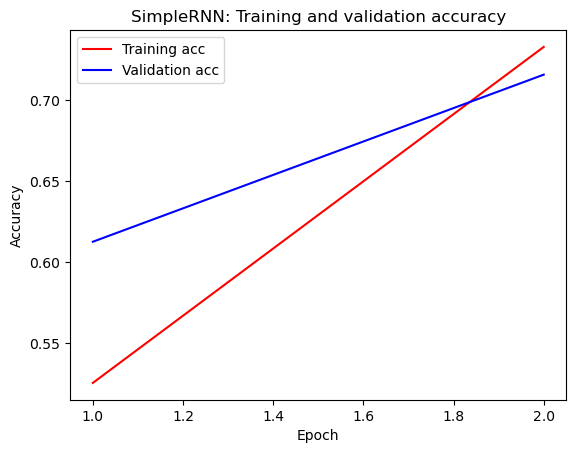

In [166]:
# SimpleRNN Result

acc = rnn_hist.history['accuracy']
val_acc = rnn_hist.history['val_accuracy']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('SimpleRNN: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

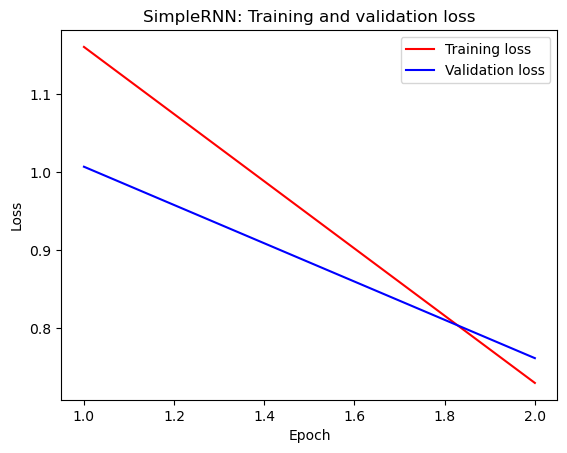

In [167]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('SimpleRNN: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

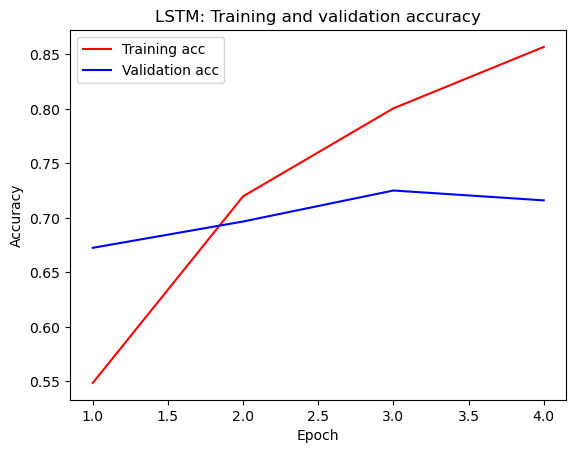

In [168]:
# LSTM Result

acc = lstm_hist.history['accuracy']
val_acc = lstm_hist.history['val_accuracy']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('LSTM: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

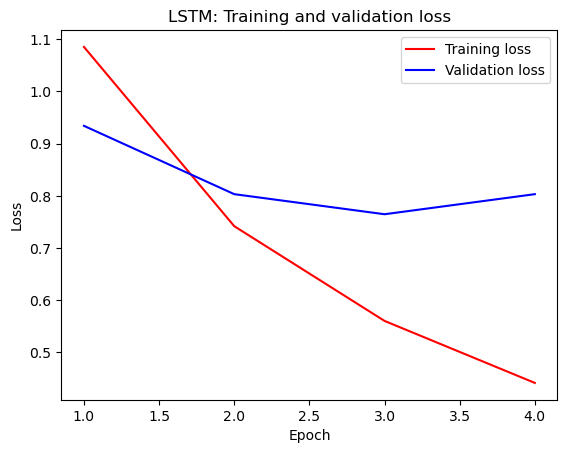

In [169]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

In [85]:
from keras.models import load_model
lstm = load_model('lstm.h5')
warnings.filterwarnings("ignore")

In [86]:
lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 14, 32)            261888    
                                                                 
 lstm_3 (LSTM)               (None, 14, 32)            8320      
                                                                 
 dropout_8 (Dropout)         (None, 14, 32)            0         
                                                                 
 lstm_4 (LSTM)               (None, 14, 32)            8320      
                                                                 
 dropout_9 (Dropout)         (None, 14, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 5)                

In [87]:
predictions = lstm.predict(X_test)

86/86 [==============================] - 3s 10ms/step


In [88]:
probability_positive = predictions[:,1]

In [89]:
len(probability_positive)

2743

In [90]:
probability_positive

array([0.19999024, 0.19995646, 0.19995205, ..., 0.1999952 , 0.20056029,
       0.20058191], dtype=float32)